%% [markdown]<br>
## Classificazione e Clustering Pokemon<br>
### Classificazione<br>
#### Cella 1: Importazioni e Preprocessing

%%

In [1]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense # type: ignore
from tensorflow.keras.models import Model, Sequential # type: ignore
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "4" # in order to avoid memory error

%%<br>
Carica il dataset

In [2]:
df = pd.read_csv("pokemon.csv")

%%<br>
Elimina le colonne duplicate

In [3]:
df.drop_duplicates(keep='first', inplace=True)

%%<br>
Seleziona le colonne numeriche

In [4]:
numeric_cols = df.select_dtypes(include=[np.number]).columns

Sostituisci i valori mancanti con la mediana di ciascuna colonna numerica

In [5]:
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

%%<br>
Seleziona le colonne di tipo object (categoriche)

In [6]:
categorical_cols = df.select_dtypes(include=['object']).columns

Sostituisci i valori mancanti con "Unknown" (o con il mode della colonna)

In [7]:
df[categorical_cols] = df[categorical_cols].fillna("Unknown")

%%<br>
Converti le colonne stringa in liste Python

In [8]:
df['type'] = df['type'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else [])
df['charged_moves'] = df['charged_moves'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else [])
df['fast_moves'] = df['fast_moves'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else [])

%%<br>
Combina le mosse in un'unica lista

In [9]:
df['all_moves'] = df['charged_moves'] + df['fast_moves']

%%<br>
Seleziona le feature numeriche

In [10]:
numeric_features = ['base_attack', 'base_defense', 'base_stamina', 'max_cp',
                    'attack_probability', 'dodge_probability',
                    'max_pokemon_action_frequency', 'min_pokemon_action_frequency']
X_numeric = df[numeric_features].values

%%<br>
Normalizza le feature numeriche

In [11]:
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric)

%%<br>
Codifica la colonna "type" usando MultiLabelBinarizer

In [12]:
mlb_type = MultiLabelBinarizer()
X_type = mlb_type.fit_transform(df['type'])

%%<br>
Codifica le mosse

In [13]:
mlb_moves = MultiLabelBinarizer()
X_moves = mlb_moves.fit_transform(df['all_moves'])

%%<br>
Combina tutte le feature in un unico vettore

In [14]:
X_combined = np.concatenate([X_numeric_scaled, X_type, X_moves], axis=1)
print("Dimensione input combinato:", X_combined.shape)

Dimensione input combinato: (1007, 263)


%% [markdown]<br>
#### Cella 2: Costruzione e Addestramento dell'Autoencoder

%%<br>
Definizione dei parametri

In [15]:
input_dim = X_combined.shape[1]
encoding_dim = 16  # Dimensione dello spazio latente

%%<br>
Definizione dell'architettura dell'autoencoder

In [16]:
input_layer = Input(shape=(input_dim,))
encoded = Dense(128, activation='relu')(input_layer)
encoded = Dense(64, activation='relu')(encoded)
latent = Dense(encoding_dim, activation='relu')(encoded)
decoded = Dense(64, activation='relu')(latent)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(input_dim, activation='linear')(decoded)

%%<br>
Costruzione del modello

In [17]:
autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')

%%<br>
Addestramento dell'autoencoder

In [18]:
autoencoder.fit(X_combined, X_combined, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0550 - val_loss: 0.0456
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0466 - val_loss: 0.0364
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0432 - val_loss: 0.0328
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0421 - val_loss: 0.0304
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0353 - val_loss: 0.0292
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0355 - val_loss: 0.0280
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0366 - val_loss: 0.0267
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0308 - val_loss: 0.0260
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0296 - val_loss: 0.0254
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0277 - val_loss: 0.0250
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0258 - val_loss: 0.0247
Epoch 12/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0265 - val_lo

%%<br>
Estrazione del modello encoder per ottenere la rappresentazione latente

In [19]:
encoder = Model(inputs=input_layer, outputs=latent)
X_latent = encoder.predict(X_combined)
print("Dimensione rappresentazione latente:", X_latent.shape)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Dimensione rappresentazione latente: (1007, 16)


%% [markdown]<br>
#### Cella 3: Analisi della Rappresentazione Latente

%%<br>
Distribuzione delle prime due componenti della rappresentazione latente

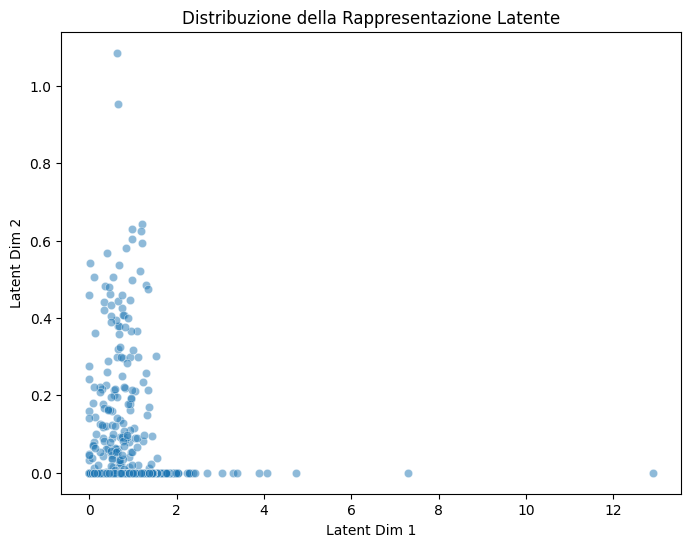

In [20]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_latent[:, 0], y=X_latent[:, 1], alpha=0.5)
plt.xlabel("Latent Dim 1")
plt.ylabel("Latent Dim 2")
plt.title("Distribuzione della Rappresentazione Latente")
plt.show()

%% [markdown]<br>
#### Cella 4: Clustering con K-Means e Silhouette Score

%%<br>
Testiamo diversi valori di K

In [21]:
wcss = []  # Within-Cluster Sum of Squares
silhouette_scores = []

In [22]:
for k in range(2, 11):  # Da 2 a 10 cluster
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_latent)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_latent, labels))

%%<br>
Grafico del metodo del gomito

Text(0.5, 1.0, 'Metodo del Gomito')

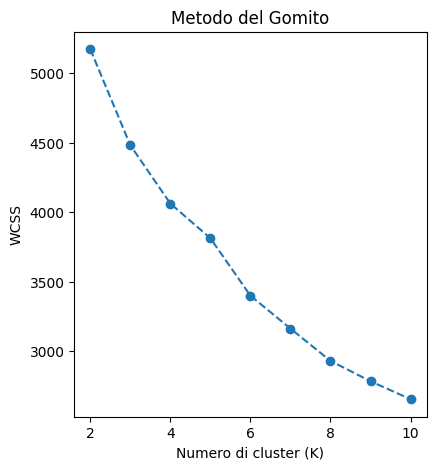

In [23]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(2, 11), wcss, marker='o', linestyle='--')
plt.xlabel("Numero di cluster (K)")
plt.ylabel("WCSS")
plt.title("Metodo del Gomito")

%%<br>
Grafico del silhouette score

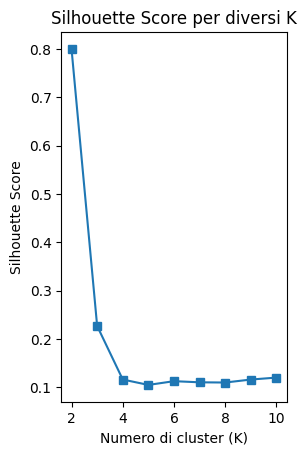

In [24]:
plt.subplot(1, 2, 2)
plt.plot(range(2, 11), silhouette_scores, marker='s', linestyle='-')
plt.xlabel("Numero di cluster (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score per diversi K")
plt.show()

%%<br>
Addestriamo K-Means con il numero ottimale di cluster (es. K=3)

In [25]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_latent)

%%<br>
Aggiungiamo le etichette dei cluster al dataset

In [26]:
df["cluster"] = clusters

%%<br>
Grafico della distribuzione dei cluster

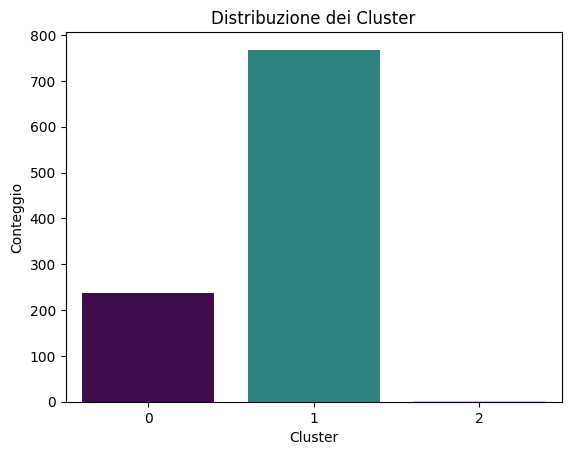

In [27]:
sns.countplot(x=df["cluster"], hue=df["cluster"], palette="viridis", legend=False)
plt.title("Distribuzione dei Cluster")
plt.xlabel("Cluster")
plt.ylabel("Conteggio")
plt.show()

%% [markdown]<br>
#### Cella 5: Random Forest Classifier

%%<br>
Classificazione con Random Forest

In [28]:
features = numeric_features
target = "rarity"

%%<br>
Questo trasforma le etichette categoriali in numeri interi

In [29]:
label_encoder = LabelEncoder()
df[target] = label_encoder.fit_transform(df[target])

%%<br>
Divide il dataset in set di addestramento e di test<br>
X_train e X_test contengono le caratteristiche (features)<br>
y_train e y_test contengono le etichette (target)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

%%<br>
Prevede le etichette per il set di test

In [31]:
y_pred = clf.predict(X_test)

%%<br>
Matrice di confusione

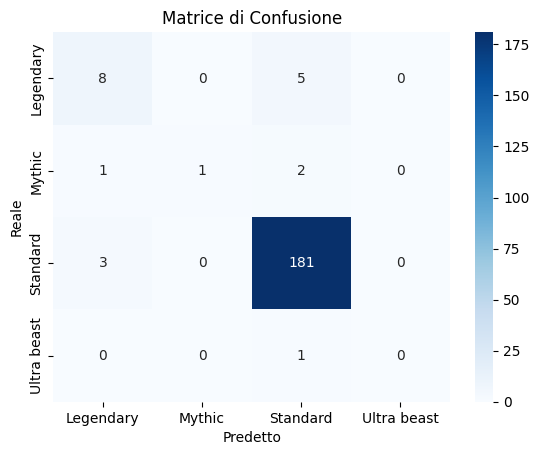

In [32]:
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=label_encoder.classes_,yticklabels=label_encoder.classes_)
plt.xlabel("Predetto")
plt.ylabel("Reale")
plt.title("Matrice di Confusione")
plt.show()

%%<br>
Report di classificazione

In [33]:
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_, zero_division=1))

              precision    recall  f1-score   support

   Legendary       0.67      0.62      0.64        13
      Mythic       1.00      0.25      0.40         4
    Standard       0.96      0.98      0.97       184
 Ultra beast       1.00      0.00      0.00         1

    accuracy                           0.94       202
   macro avg       0.91      0.46      0.50       202
weighted avg       0.94      0.94      0.93       202



%%<br>
Importanza delle feature

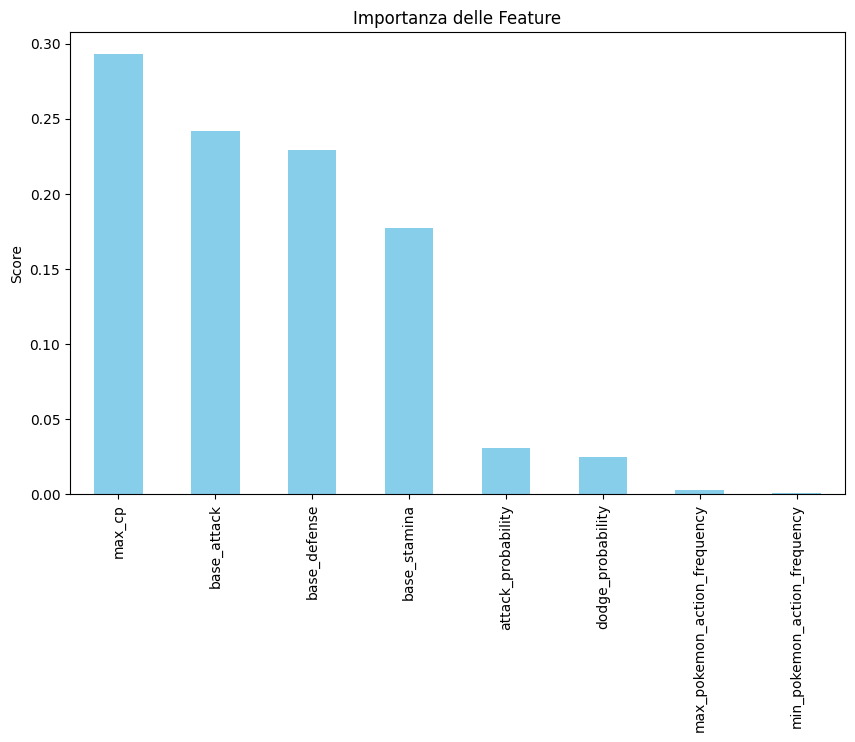

In [34]:
feature_importances = pd.Series(clf.feature_importances_, index=features).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar', color='skyblue')
plt.title("Importanza delle Feature")
plt.ylabel("Score")
plt.show()

%%<br>
Heatmap della correlazione

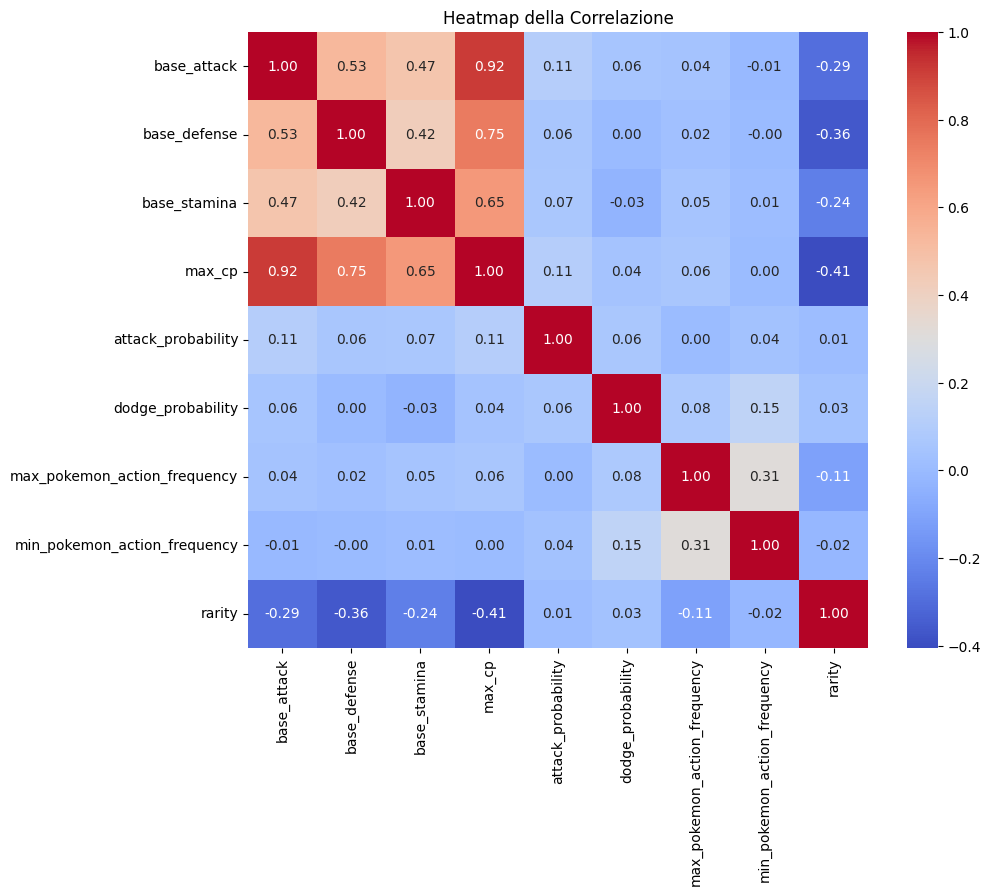

In [35]:
plt.figure(figsize=(10, 8))
sns.heatmap(df[features + [target]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Heatmap della Correlazione")
plt.show()

%%<br>
Distribuzione della raritÃ 

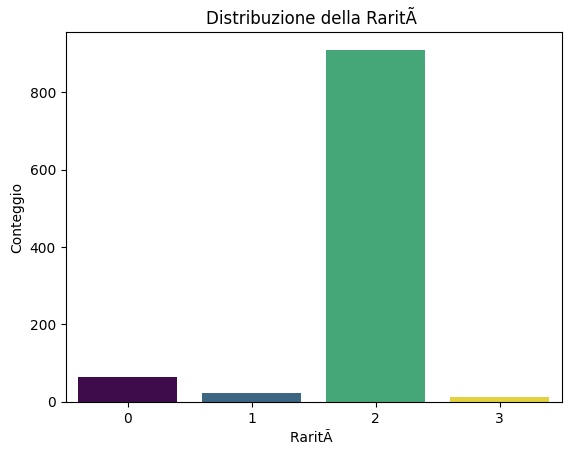

In [36]:
sns.countplot(x=df[target], hue=df[target], palette="viridis", legend=False)
plt.title("Distribuzione della RaritÃ ")
plt.xlabel("RaritÃ ")
plt.ylabel("Conteggio")
plt.show()

%% [markdown]<br>
#### Cella 6: Definizione del Target PvP vs. PvE

%%<br>
Definiamo insiemi euristici per le mosse

In [37]:
pvp_moves = {'Counter', 'Quick Attack', 'Vine Whip', 'Tackle', 'Bug Bite', 'Ember', 
            'Scratch', 'Water Gun', 'Bubble', 'Wing Attack', 'Peck'}
pve_moves = {'Hydro Cannon', 'Blast Burn', 'Solar Beam', 'Flamethrower', 'Dragon Claw', 
            'Skull Bash', 'Ice Beam', 'Hydro Pump'}

%%<br>
Funzione per assegnare lo stile PvP (0) o PvE (1)

In [38]:
def assign_style(row):
    moves = set(row['all_moves'])
    if moves.intersection(pvp_moves) and not moves.intersection(pve_moves):
        return 0  # PvP
    else:
        return 1  # PvE

%%

In [39]:
df['style'] = df.apply(assign_style, axis=1)
y = df['style'].values
print("Distribuzione stili:\n", pd.Series(y).value_counts())

Distribuzione stili:
 1    642
0    365
Name: count, dtype: int64


%% [markdown]<br>
#### Cella 7: Classificazione Supervisionata sui Dati Latenti

%%<br>
Suddividi i dati in training e test

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_latent, y, test_size=0.2, random_state=42)

%%<br>
Costruzione del classificatore (rete neurale)

In [41]:
classifier = Sequential()
classifier.add(Dense(32, activation='relu', input_dim=encoding_dim))
classifier.add(Dense(16, activation='relu'))
classifier.add(Dense(1, activation='sigmoid'))

C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [42]:
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
classifier.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2)

Epoch 1/50


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6494 - loss: 0.6521 - val_accuracy: 0.6832 - val_loss: 0.6106
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6603 - loss: 0.6189 - val_accuracy: 0.6894 - val_loss: 0.5929
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6904 - loss: 0.6036 - val_accuracy: 0.7205 - val_loss: 0.5739
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7054 - loss: 0.6020 - val_accuracy: 0.7081 - val_loss: 0.5673
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7281 - loss: 0.5695 - val_accuracy: 0.7391 - val_loss: 0.5512
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6900 - loss: 0.5888 - val_accuracy: 0.7391 - val_loss: 0.5465
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6897 - loss: 0.5843 - val_accuracy: 0.7205 - val_loss: 0.5420
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7248 - loss: 0.5555 - val_accuracy: 0.7205 - val_loss: 0.5352
Epo

%%<br>
Valutazione del modello

In [43]:
loss, accuracy = classifier.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7565 - loss: 0.5732 
Test Accuracy: 0.7524752616882324


%% [markdown]<br>
### Clustering<br>
#### Cella 1: Trovare il numero ottimale di cluster (Metodo del Gomito)

%%

In [44]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "4"  # Cambia il numero in base ai core del tuo PC

%%<br>
Testiamo diversi valori di K

In [45]:
wcss = []  # Within-Cluster Sum of Squares

In [46]:
for k in range(1, 11):  # Da 1 a 10 cluster
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_latent)
    wcss.append(kmeans.inertia_)  # Inertia = somma delle distanze dei punti dal centroide

%%<br>
Grafico del metodo del gomito

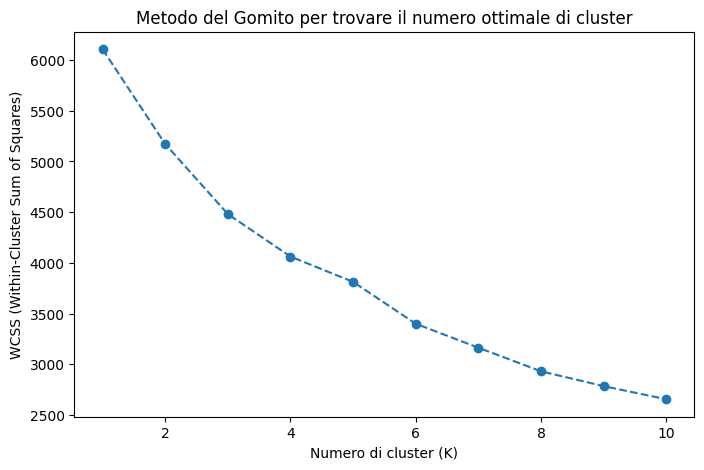

In [47]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.xlabel("Numero di cluster (K)")
plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
plt.title("Metodo del Gomito per trovare il numero ottimale di cluster")
plt.show()

%% [markdown]<br>
#### Cella 2: Applicare K-Means con il numero ottimale di cluster

%%<br>
Addestriamo K-Means con il numero ottimale di cluster (es. K=3)

In [48]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_latent)

%%<br>
Aggiungiamo le etichette dei cluster al dataset

In [49]:
df["cluster"] = clusters

%%<br>
Visualizziamo la distribuzione dei cluster

In [50]:
print(df["cluster"].value_counts())

cluster
1    768
0    237
2      2
Name: count, dtype: int64


%% [markdown]<br>
#### Cella 3: Visualizzare i cluster con PCA (2D)

%%<br>
Riduzione a 2 componenti principali

In [51]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_latent)

%%

Creiamo un DataFrame con i dati ridotti e le etichette dei cluster

In [52]:
df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_pca["cluster"] = clusters

%%<br>
Grafico dei cluster

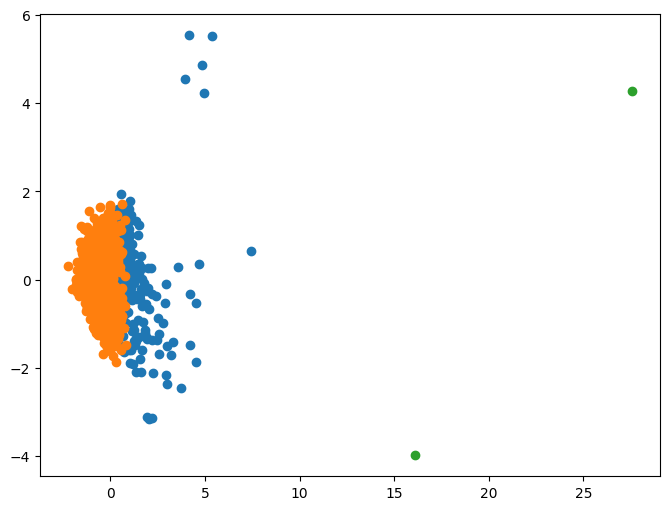

In [53]:
plt.figure(figsize=(8, 6))
for cluster in range(kmeans.n_clusters):
    subset = df_pca[df_pca["cluster"] == cluster]
    plt.scatter(subset["PC1"], subset["PC2"], label=f"Cluster {cluster}")

%%

%%

%%

%%

%%

%%

%%

%%

%%

%%